In [7]:
import pandas as pd
import numpy as np
import sys
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

In [8]:
# Import
from pathlib import Path
from src.build_dataset import build_dataset

# Root path direction
# ROOT = Path(__file__).resolve().parent.parent
ROOT = Path.cwd().parent
DATA = ROOT / "data"

# train, test, dev
zip_path = DATA / 'raw' / 'lang-8.zip'
train = DATA / 'train.txt'
dev = DATA / 'dev.txt'
test = DATA / 'test.txt'
X_train, y_train, X_dev, y_dev, X_test, y_test = build_dataset(zip_path, train, dev, test)

[nltk_data] Downloading package punkt to /Users/snalyf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/snalyf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/snalyf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Vectorization
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse = True)

X_train_vec = vec.fit_transform(X_train)
X_dev_vec = vec.transform(X_dev)
X_test_vec = vec.transform(X_test)

# Sparse to dense np arrays
X_train_array = X_train_vec.toarray()
X_dev_array = X_dev_vec.toarray()
X_test_array = X_test_vec.toarray()

In [10]:
# Baseline model
from sklearn.tree import DecisionTreeClassifier

baseline = DecisionTreeClassifier(random_state = 521, max_depth = 3)
baseline.fit(X_train_array, y_train)
print(f'baseline accuracy = {baseline.score(X_dev_array, y_dev)}')

baseline accuracy = 0.7195121951219512


In [11]:
def feature_ablation(vec, index, X_train_array, y_train, X_dev_array, y_dev):
    
    baseline = DecisionTreeClassifier(random_state = 521, max_depth = 4)
    baseline.fit(X_train_array, y_train)
    base_score = baseline.score(X_dev_array, y_dev)
    
    n_features = X_train_array.shape[1]
    keep_cols = np.delete(np.arange(n_features), index)
    
    X_train = X_train_array[: , keep_cols]
    X_dev = X_dev_array[: , keep_cols]

    model = DecisionTreeClassifier(random_state = 521, max_depth = 4)
    model.fit(X_train, y_train)
    
    accuracy = model.score(X_dev, y_dev)
    delta = base_score - accuracy

    #base score = all features, accrauracy = -1 selected feature, if base - acc > 0,  base high, acc low, feature important, else, feature not important or draging down
    
    return index, vec.feature_names_[index], accuracy * 100, delta * 100

In [16]:
result = []
for index, feature in enumerate(vec.feature_names_):
    result.append(feature_ablation(vec, index, X_train_array, y_train, X_dev_array, y_dev))
sorted(result, key = lambda x: x[3])

[(0, 'Religious_Feature', 73.57723577235772, 0.0),
 (3, 'asian_top_word_match', 73.57723577235772, 0.0),
 (4, 'avg_sent_len_tokens', 73.57723577235772, 0.0),
 (6, 'mean_word_len', 73.57723577235772, 0.0),
 (7, 'modal_verb_ratio', 73.57723577235772, 0.0),
 (9, 'pronoun_density', 73.57723577235772, 0.0),
 (12, 'sent_per_100_tokens', 73.57723577235772, 0.0),
 (2, 'article_ratio', 73.17073170731707, 0.40650406504064707),
 (1, 'adjective_ratio', 72.76422764227642, 0.8130081300812941),
 (8, 'preposition_ratio', 72.76422764227642, 0.8130081300812941),
 (11, 'sent_cv_log', 72.35772357723577, 1.2195121951219412),
 (5, 'hapax_ratio', 71.95121951219512, 1.6260162601625994),
 (10, 'punct_per_token', 71.13821138211382, 2.4390243902438935),
 (13, 'unique_lemma_ratio', 69.51219512195121, 4.0650406504065035)]

In [45]:
ablation_features = []
for index, feature, score, delta in result:
    if delta == 0:
        ablation_features.append(index)
ablation_features

[]

In [46]:
test_tree = DecisionTreeClassifier(max_depth = 4, random_state = 521)
n_features = X_train_array.shape[1]
keep_cols = np.delete(np.arange(n_features), ablation_features)
test_tree.fit(X_train_array[:, keep_cols], y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,521
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
print(f'Test Score after feature ablation: {test_tree.score(X_test_array[:, keep_cols], y_test)}')

0.6349206349206349

In [27]:
### Part_5

In [28]:
X_train = pd.DataFrame(X_train)
X_dev = pd.DataFrame(X_dev)
X_test = pd.DataFrame(X_test)

In [29]:
train = X_train
train['target'] = y_train

In [30]:
cat_cols = train.select_dtypes(include = ['bool', 'object']).columns.tolist()

In [31]:
import altair_ally as aly
aly.alt.data_transformers.enable('vegafusion')

aly.dist(X_train, color = 'target').resolve_scale(y = 'independent')

alt.ConcatChart(...)

In [32]:
# Distribution of categoricals
import altair as alt

cat_train = train[cat_cols].melt(id_vars = 'target', var_name = 'variable', value_name = 'value')

alt.Chart(cat_train).mark_bar().encode(
    x = alt.X('value:N').title('Category'),
    y = alt.Y('count()').title('Count'),
    color = 'target'
).properties(
    width = 150,
    height = 150
).facet(
    'variable:N',
    columns = 3
)

alt.FacetChart(...)

In [33]:
aly.corr(train)

alt.ConcatChart(...)

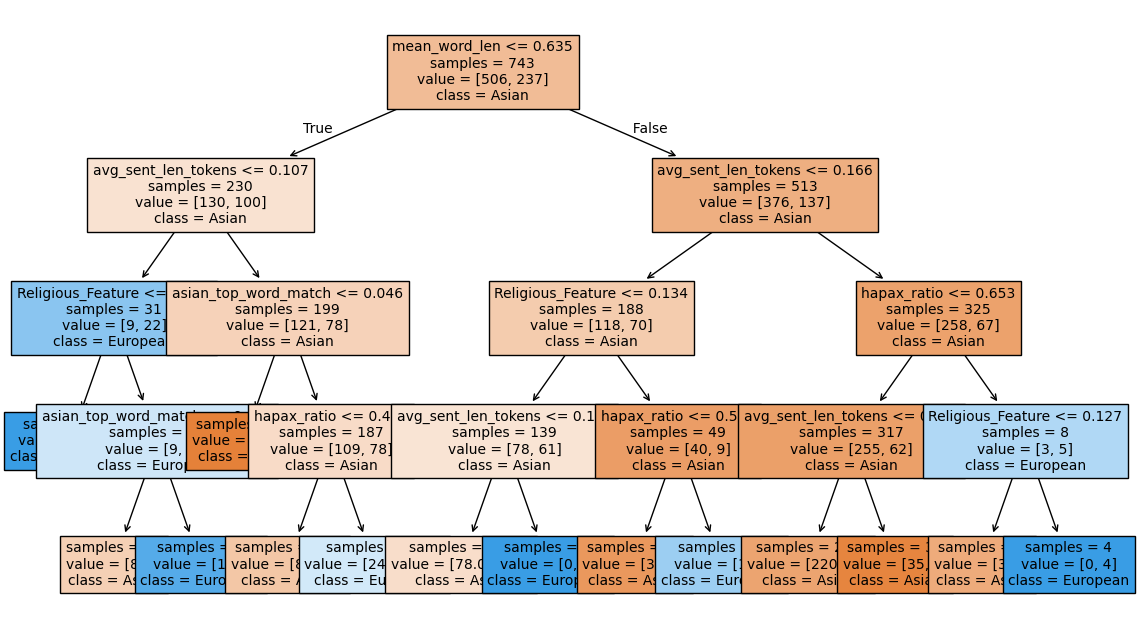

In [34]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(14, 8))
plot_tree(
    test_tree,
    feature_names=vec.feature_names_,
    class_names=["Asian", "European"],
    filled=True,
    impurity=False,
    fontsize=10
)
plt.show()

In [35]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm, randint

search_grid = {
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, 'balanced']
}

tree = DecisionTreeClassifier(random_state = 521)
grid_search = GridSearchCV(
    estimator = tree,
    param_grid= search_grid,
    scoring = 'accuracy'
)

In [36]:
grid_search.fit(X_train_array, y_train)

,estimator,DecisionTreeC...dom_state=521)
,param_grid,"{'class_weight': [None, 'balanced'], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, ...], 'max_features': [None, 'sqrt', ...], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [37]:
grid_search.best_estimator_

,criterion,'entropy'
,splitter,'best'
,max_depth,6
,min_samples_split,50
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,random_state,521
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

best_tree = grid_search.best_estimator_

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 521)
rfecv = RFECV(estimator = best_tree, n_jobs = -1, verbose = 1, cv = cv, scoring = 'accuracy')

In [39]:
rfecv.fit(X_train_array, y_train)

,estimator,DecisionTreeC...dom_state=521)
,step,1
,min_features_to_select,1
,cv,StratifiedKFo... shuffle=True)
,scoring,'accuracy'
,verbose,1
,n_jobs,-1
,importance_getter,'auto'
,criterion,'entropy'
,splitter,'best'
,max_depth,6


In [40]:
rfecv.get_support

<bound method SelectorMixin.get_support of RFECV(cv=StratifiedKFold(n_splits=5, random_state=521, shuffle=True),
      estimator=DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                       max_features='sqrt', min_samples_leaf=20,
                                       min_samples_split=50, random_state=521),
      n_jobs=-1, scoring='accuracy', verbose=1)>

In [41]:
[f for f, keep in zip(vec.feature_names_, rfecv.get_support()) if keep]

['Religious_Feature',
 'adjective_ratio',
 'article_ratio',
 'asian_top_word_match',
 'avg_sent_len_tokens',
 'hapax_ratio',
 'mean_word_len',
 'modal_verb_ratio',
 'preposition_ratio',
 'pronoun_density',
 'punct_per_token',
 'sent_cv_log',
 'sent_per_100_tokens',
 'unique_lemma_ratio']

In [42]:
print(f'Dev prediciton score with Hyperparameter optimization and feature selection: {rfecv.score(X_dev_array, y_dev)}')

Dev prediciton score with Hyperparameter optimization and feature selection: 0.7317073170731707


In [43]:
print(f'Test prediciton score with Hyperparameter optimization and feature selection: {rfecv.score(X_test_array, y_test)}')

Test prediciton score with Hyperparameter optimization and feature selection: 0.7063492063492064
